# Yelp Dataset Analysis - Restaurant Ratings

In [101]:
import csv
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
from statsmodels.formula.api import ols

from IPython.display import HTML, display
%matplotlib inline

Import custom restauramt and not_restaurant csv files as dataframes

In [102]:
restaurant_df = pd.read_csv('is_restaurant.csv')
restaurant_df = restaurant_df.drop(['Unnamed: 0','city'], 1)
restaurant_df = restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude'], keep=False)
restaurant_df['index_no'] = restaurant_df.index

not_restaurant_df = pd.read_csv('not_restaurant.csv')
not_restaurant_df = not_restaurant_df.drop(['Unnamed: 0','city','distance'], 1)
not_restaurant_df = not_restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude'], keep=False)
not_restaurant_df['index_no'] = not_restaurant_df.index


In [103]:
not_restaurant_df.head()

,name,postal_code,latitude,longitude,neighborhood,categories,stars,review_count,hours.Monday,index_no
0,Adelaide Hall,M5H 1X6,43.648171,-79.389077,Entertainment District,"[u'Nightlife', u'Music Venues', u'DJs', u'Arts...",3.5,10,10:00-1:00,0
1,Sangria Lounge,M6R 2K9,43.643537,-79.447954,High Park,"[u'Nightlife', u'Lounges', u'Beer', u'Wine & S...",3.5,23,11:00-1:00,1
2,Empire Customs,M5V 4A6,43.639650,-79.397931,City Place,"[u'Accessories', u'Bespoke Clothing', u""Men's ...",3.0,4,NaN,2
3,Second Cup,M5N 1A5,43.703641,-79.413688,NaN,"[u'Juice Bars & Smoothies', u'Desserts', u'Cof...",4.0,7,6:00-21:00,3
4,Organic Nail Bar,M5V 0C6,43.638308,-79.400758,NaN,"[u'Hair Removal', u'Beauty & Spas', u'Waxing',...",3.5,21,10:00-21:00,4


## Rating of Restaurants Based on the Ratings of Other Restaurants Around It

In [91]:
restaurant_rating_df = pd.DataFrame()

def haversine(x):
    
    global restaurant_df
    global restaurant_rating_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(restaurant_df['latitude']), np.radians(restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = restaurant_df
    measure_1 = measure_1.loc[measure_1['distance'] <= 1]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    restaurant_rating_df = restaurant_rating_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, 'neighborhood':x['neighborhood'].item(), 'hours_of_service':x['hours.Monday'].item()}, ignore_index=True)
    return restaurant_rating_df


for line in restaurant_df['index_no']:
    x = restaurant_df.loc[restaurant_df['index_no'] == line]
    haversine(x)


In [92]:
restaurant_rating_df.head()

,hours_of_service,mean_business_rating,name,neighborhood,rating
0,14:00-2:00,3.914286,McCarthy's Irish Pub,Upper Beach,4.0
1,NaN,3.000000,Oishi Sushi,NaN,2.0
2,8:00-16:00,3.315789,Boardwalk Place,NaN,3.0
3,11:30-23:00,3.394273,Big Daddy's Bourbon Street Bistro & Oyster Bar,Entertainment District,3.5
4,11:00-23:00,3.631579,Sushi Osaka,Etobicoke,4.5


In [93]:
restaurant_rating_df = restaurant_rating_df[(restaurant_rating_df.rating >= 2.5)]

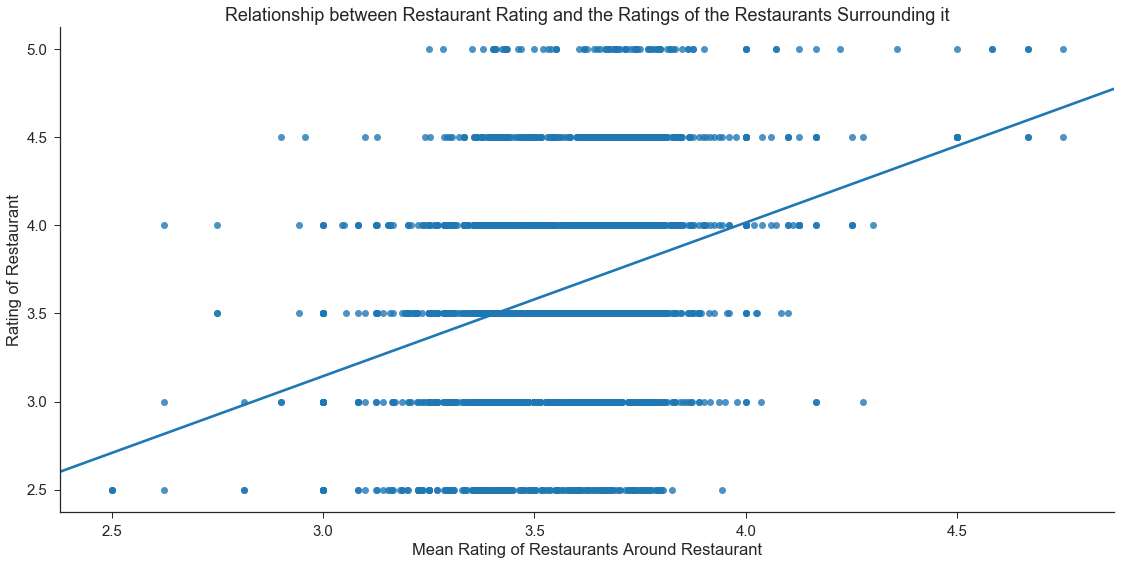

In [94]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8,ci=None, data = restaurant_rating_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurant Rating and the Ratings of the Restaurants Surrounding it")
plt.xlabel('Mean Rating of Restaurants Around Restaurant')
plt.ylabel('Rating of Restaurant')

plt.savefig("Relationship between Restaurant Rating and the Ratings of the Restaurants Surrounding it.png")

In [110]:

restaurant_rating_df.describe()

,mean_business_rating,rating
count,3199.000000,3199.000000
mean,3.553834,3.626289
std,0.218517,0.611025
min,2.500000,2.500000
25%,3.409091,3.000000
50%,3.548387,3.500000
75%,3.700000,4.000000
max,4.750000,5.000000


In [111]:
restaurant_rating_df['mean_business_rating'].corr(restaurant_rating_df['rating'])

0.31167118728759452

In [96]:
restaurant_model = ols("rating ~ mean_business_rating + neighborhood + hours_of_service", data=restaurant_rating_df).fit()
restaurant_model_summary = restaurant_model.summary()
restaurant_model_summary
#restaurant_model.savefig("OLS for Restaurant Rating and the Ratings of the Restaurants Surrounding it.png")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2.106
Date:                Sun, 03 Dec 2017   Prob (F-statistic):           4.75e-23
Time:                        18:05:36   Log-Likelihood:                -1349.4
No. Observations:                1950   AIC:                             3443.
Df Residuals:                    1578   BIC:                             5517.
Df Model:                         371                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.5160      0.357      1.447      0.148      -0.184       1.215
neighborhood[T.Bayview Village]                  -0.0826      0.269     -0.307      0.759      -0.611       0.445
neighborhood[T.Beaconsfield Village]          -1.602e-14   8.31e-15     -1.926      0.054   -3.23e-14    2.93e-16
neighborhood[T.Bickford Park]                     0.1321      0.196      0.674      0.500      -0.252       0.516
neighborhood[T.Bloor-West Village]               -0.1011      0.167     -0.606      0.545      -0.428       0.226
neighborhood[T.Bloordale Village]                 0.0572      0.172      0.332      0.740      -0.280       0.395
neighborhood[T.Brockton Village]                 -0.0735      0.189     -0.389      0.697      -0.444       0.297
neighborhood[T.Cabbagetown]                       0.2051      0.162      1.268      0.205      -0.112       0.522
neighborhood[T.Casa Loma]                        -0.9418      0.458     -2.056      0.040      -1.840      -0.043
neighborhood[T.Chinatown]                         0.0706      0.138      0.511      0.609      -0.200       0.342
neighborhood[T.Christie Pits]                    -0.0802      0.231     -0.348      0.728      -0.533       0.372
neighborhood[T.Church-Wellesley Village]          0.0694      0.126      0.550      0.582      -0.178       0.317
neighborhood[T.City Place]                        0.0531      0.218      0.244      0.807      -0.374       0.480
neighborhood[T.Corktown]                          0.1772      0.134      1.321      0.187      -0.086       0.440
neighborhood[T.Corso Italia]                      0.3515      0.413      0.851      0.395      -0.459       1.162
neighborhood[T.Discovery District]               -0.0531      0.139     -0.381      0.703      -0.327       0.220
neighborhood[T.Distillery District]               0.0470      0.209      0.225      0.822      -0.364       0.458
neighborhood[T.Dovercourt]                        0.0030      0.170      0.018      0.986      -0.330       0.337
neighborhood[T.Downsview]                         0.5043      0.252      2.001      0.046       0.010       0.999
neighborhood[T.Downtown Core]                     0.0823      0.106      0.776      0.438      -0.126       0.290
neighborhood[T.Dufferin Grove]                    0.0164      0.150      0.109      0.913      -0.279       0.312
neighborhood[T.East York]                         0.0493      0.262      0.188      0.851      -0.465       0.564
neighborhood[T.Entertainment District]            0.0760      0.112      0.678      0.498      -0.144       0.296
neighborhood[T.Etobicoke]                         0.1115      0.114      0.981      0.327      -0.111       0.334
neigh

## Ratings of Restaurants Based on Ratings of Non-Restaurant Businesses

In [104]:
final_nonrestaurants_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global final_nonrestaurants_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
    measure_1 = measure_1.loc[measure_1['distance'] <= 1.0]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()

    final_nonrestaurants_df = final_nonrestaurants_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, 'neighborhood':x['neighborhood'].item(), 'hours_of_service':x['hours.Monday'].item() }, ignore_index=True)
    return final_nonrestaurants_df


for line in restaurant_df['index_no']:
    x = restaurant_df.loc[restaurant_df['index_no'] == line]
    haversine(x)


In [105]:
final_nonrestaurants_df = final_nonrestaurants_df[ (final_nonrestaurants_df.mean_business_rating >= 1.5)]
final_nonrestaurants_df = final_nonrestaurants_df[(final_nonrestaurants_df.rating >= 2.5)]


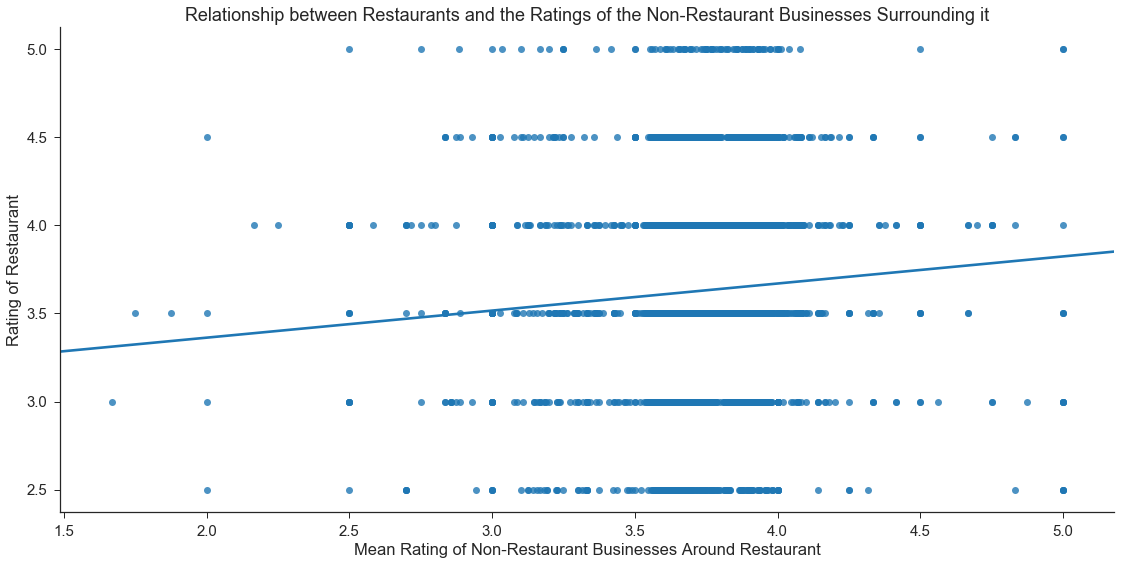

In [106]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8, ci=None, data=final_nonrestaurants_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurants and the Ratings of the Non-Restaurant Businesses Surrounding it")
plt.xlabel('Mean Rating of Non-Restaurant Businesses Around Restaurant')
plt.ylabel('Rating of Restaurant')

plt.savefig("Relationship between Restaurant Rating and the Ratings of the Non-Restaurant Businesses Surrounding it.png")

In [107]:
final_nonrestaurants_df.describe()

,mean_business_rating,rating
count,3147.000000,3147.000000
mean,3.716373,3.625834
std,0.297814,0.609881
min,1.666667,2.500000
25%,3.616071,3.000000
50%,3.703540,3.500000
75%,3.875379,4.000000
max,5.000000,5.000000


In [108]:
final_nonrestaurants_df['mean_business_rating'].corr(final_nonrestaurants_df['rating'])

0.074997975319147619

In [109]:
non_restaurant_model = ols("rating ~ mean_business_rating + neighborhood + hours_of_service", data=final_nonrestaurants_df).fit()
non_restaurant_model_summary = restaurant_model.summary()
non_restaurant_model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     2.106
Date:                Sun, 03 Dec 2017   Prob (F-statistic):           4.75e-23
Time:                        18:11:53   Log-Likelihood:                -1349.4
No. Observations:                1950   AIC:                             3443.
Df Residuals:                    1578   BIC:                             5517.
Df Model:                         371                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.5160      0.357      1.447      0.148      -0.184       1.215
neighborhood[T.Bayview Village]                  -0.0826      0.269     -0.307      0.759      -0.611       0.445
neighborhood[T.Beaconsfield Village]          -1.602e-14   8.31e-15     -1.926      0.054   -3.23e-14    2.93e-16
neighborhood[T.Bickford Park]                     0.1321      0.196      0.674      0.500      -0.252       0.516
neighborhood[T.Bloor-West Village]               -0.1011      0.167     -0.606      0.545      -0.428       0.226
neighborhood[T.Bloordale Village]                 0.0572      0.172      0.332      0.740      -0.280       0.395
neighborhood[T.Brockton Village]                 -0.0735      0.189     -0.389      0.697      -0.444       0.297
neighborhood[T.Cabbagetown]                       0.2051      0.162      1.268      0.205      -0.112       0.522
neighborhood[T.Casa Loma]                        -0.9418      0.458     -2.056      0.040      -1.840      -0.043
neighborhood[T.Chinatown]                         0.0706      0.138      0.511      0.609      -0.200       0.342
neighborhood[T.Christie Pits]                    -0.0802      0.231     -0.348      0.728      -0.533       0.372
neighborhood[T.Church-Wellesley Village]          0.0694      0.126      0.550      0.582      -0.178       0.317
neighborhood[T.City Place]                        0.0531      0.218      0.244      0.807      -0.374       0.480
neighborhood[T.Corktown]                          0.1772      0.134      1.321      0.187      -0.086       0.440
neighborhood[T.Corso Italia]                      0.3515      0.413      0.851      0.395      -0.459       1.162
neighborhood[T.Discovery District]               -0.0531      0.139     -0.381      0.703      -0.327       0.220
neighborhood[T.Distillery District]               0.0470      0.209      0.225      0.822      -0.364       0.458
neighborhood[T.Dovercourt]                        0.0030      0.170      0.018      0.986      -0.330       0.337
neighborhood[T.Downsview]                         0.5043      0.252      2.001      0.046       0.010       0.999
neighborhood[T.Downtown Core]                     0.0823      0.106      0.776      0.438      -0.126       0.290
neighborhood[T.Dufferin Grove]                    0.0164      0.150      0.109      0.913      -0.279       0.312
neighborhood[T.East York]                         0.0493      0.262      0.188      0.851      -0.465       0.564
neighborhood[T.Entertainment District]            0.0760      0.112      0.678      0.498      -0.144       0.296
neighborhood[T.Etobicoke]                         0.1115      0.114      0.981      0.327      -0.111       0.334
neigh

# Quality and Quantity

We are interested in understanding if quality drives competition and market size. 

In [49]:
restaurant_count_df = pd.DataFrame()

def haversine(x):
    
    global restaurant_df
    global restaurant_count_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(restaurant_df['latitude']), np.radians(restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = restaurant_df
    measure_1 = measure_1.loc[restaurant_df['distance'] <=0.5]
    
    # Calculate the number of pubs
    restaurant_count = len(measure_1.index)
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    restaurant_count_df = restaurant_count_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'restaurant_count':restaurant_count}, ignore_index=True)
    return restaurant_count_df


for line in restaurant_df['index_no']:
    x = restaurant_df.loc[restaurant_df['index_no'] == line]
    haversine(x)


In [50]:
#pub_count_df = pub_count_df[(pub_count_df.rating >= 2.7)]


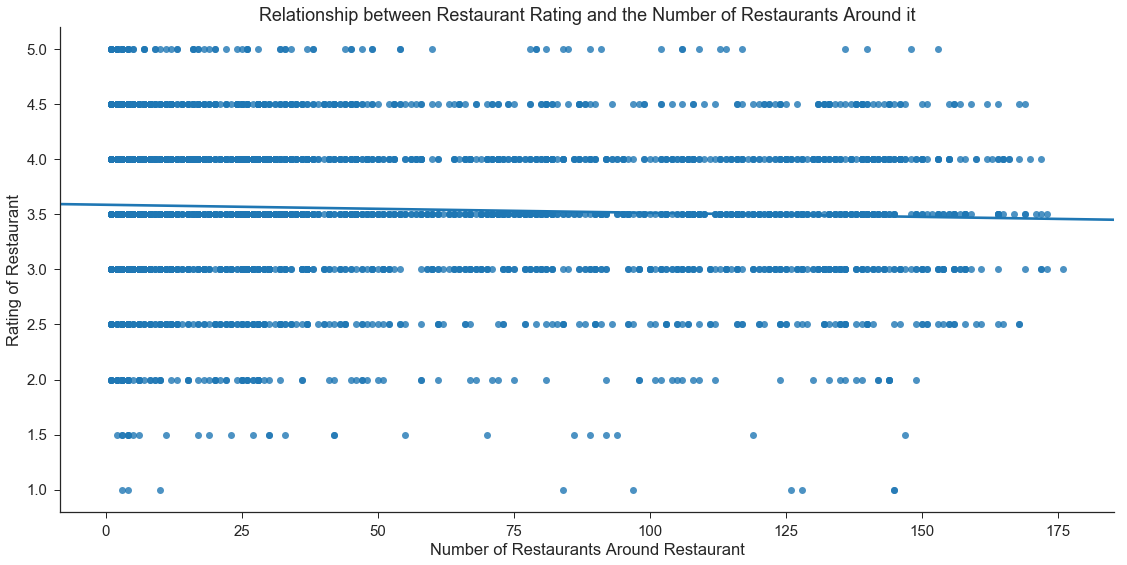

In [52]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="restaurant_count", y="rating", size=8, ci=None, data=restaurant_count_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurant Rating and the Number of Restaurants Around it")
plt.xlabel('Number of Restaurants Around Restaurant')
plt.ylabel('Rating of Restaurant')

plt.savefig("Relationship between Restaurant Rating and the Number of Restaurants Around It.png")

In [22]:
not_restaurant_count_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global not_restaurant_count_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
    measure_1 = measure_1.loc[not_restaurant_df['distance'] <=1]
    
    # Calculate the number of pubs
    not_restaurant_count = len(measure_1.index)
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    not_restaurant_count_df = not_restaurant_count_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'not_restaurant_count':not_restaurant_count}, ignore_index=True)
    return not_restaurant_count_df


for line in not_restaurant_df['index_no']:
    x = not_restaurant_df.loc[not_restaurant_df['index_no'] == line]
    haversine(x)


In [23]:
#business_count_df = business_count_df[(business_count_df.rating >= 2) & (business_count_df.pub_count <= 175)]
#business_count_df = business_count_df[(business_count_df.rating >= 2.4)]


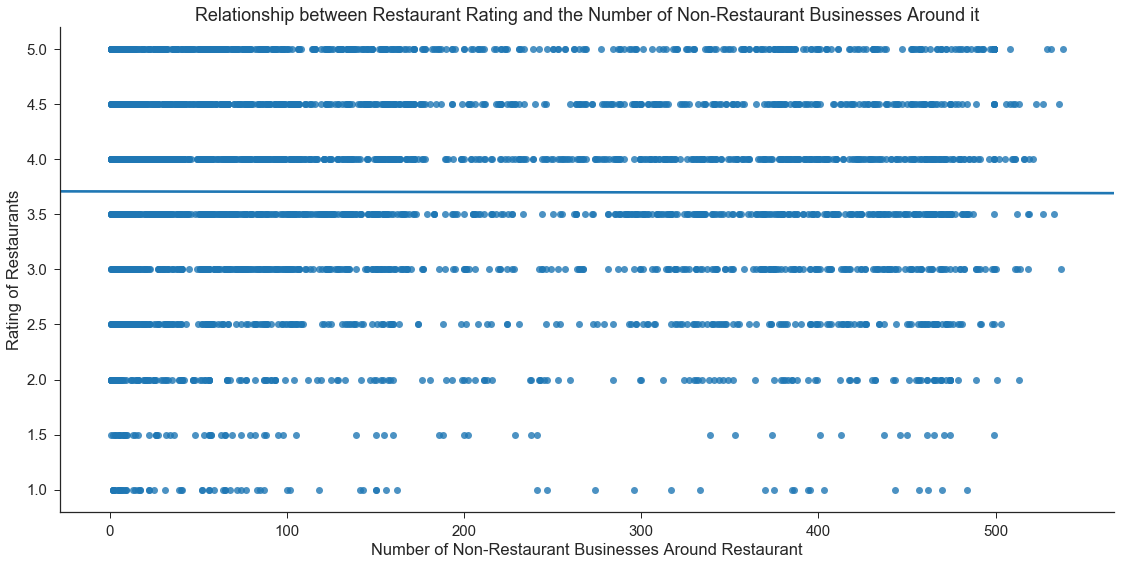

In [24]:
#Set style-
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="not_restaurant_count", y="rating", size=8, ci=None, data=not_restaurant_count_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Restaurant Rating and the Number of Non-Restaurant Businesses Around it")
plt.xlabel('Number of Non-Restaurant Businesses Around Restaurant')
plt.ylabel('Rating of Restaurants')

plt.savefig("Relationship between Restaurant Rating and the Number of the Non-Restaurant Businesses Around It.png")

# How Many Restaurants Near Good Restaurants

In [25]:
good_restaurants_df = restaurant_df.loc[restaurant_df['stars'] >=3.5]

In [26]:
good_restaurant_count_df = pd.DataFrame()

def haversine(x):
    
    global good_restaurants_df
    global good_restaurant_count_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(good_restaurants_df['latitude']), np.radians(good_restaurants_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    good_restaurants_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = good_restaurants_df
    measure_1 = measure_1.loc[good_restaurants_df['distance'] <=1]
    
    # Calculate the number of pubs
    good_restaurant_count = len(measure_1.index)
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    good_restaurant_count_df = good_restaurant_count_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'good_restaurant_count':good_restaurant_count}, ignore_index=True)
    return good_restaurant_count_df


for line in good_restaurants_df['index_no']:
    x = good_restaurants_df.loc[good_restaurants_df['index_no'] == line]
    haversine(x)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


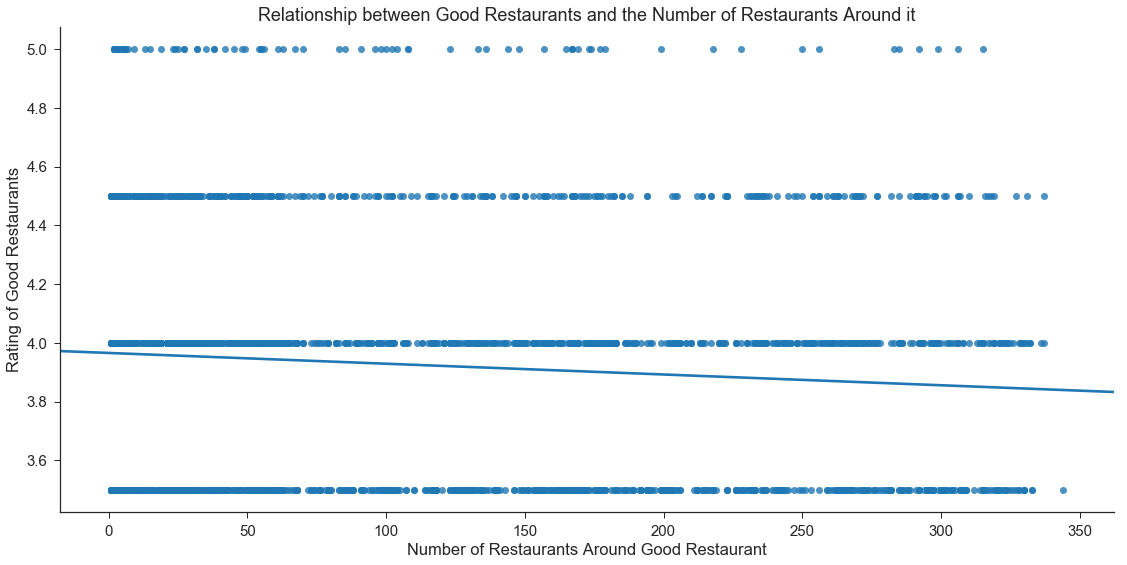

In [27]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="good_restaurant_count", y="rating", size=8, ci=None, data=good_restaurant_count_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Good Restaurants and the Number of Restaurants Around it")
plt.xlabel('Number of Restaurants Around Good Restaurant')
plt.ylabel('Rating of Good Restaurants')

plt.savefig("Relationship between Good Restaurants and the Number of Restaurants Around it.png")

# How does Quantity Affect Bad Restaurants

In [28]:
bad_restaurants_df = restaurant_df.loc[restaurant_df['stars'] <=2.5]

In [29]:
bad_restaurant_count_df = pd.DataFrame()

def haversine(x):
    
    global bad_restaurants_df
    global bad_restaurant_count_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(bad_restaurants_df['latitude']), np.radians(bad_restaurants_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    bad_restaurants_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = bad_restaurants_df
    measure_1 = measure_1.loc[bad_restaurants_df['distance'] <=1]
    
    # Calculate the number of pubs
    bad_restaurant_count = len(measure_1.index)
    #density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    bad_restaurant_count_df = bad_restaurant_count_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'bad_restaurant_count':bad_restaurant_count}, ignore_index=True)
    return bad_restaurant_count_df


for line in bad_restaurants_df['index_no']:
    x = bad_restaurants_df.loc[bad_restaurants_df['index_no'] == line]
    haversine(x)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


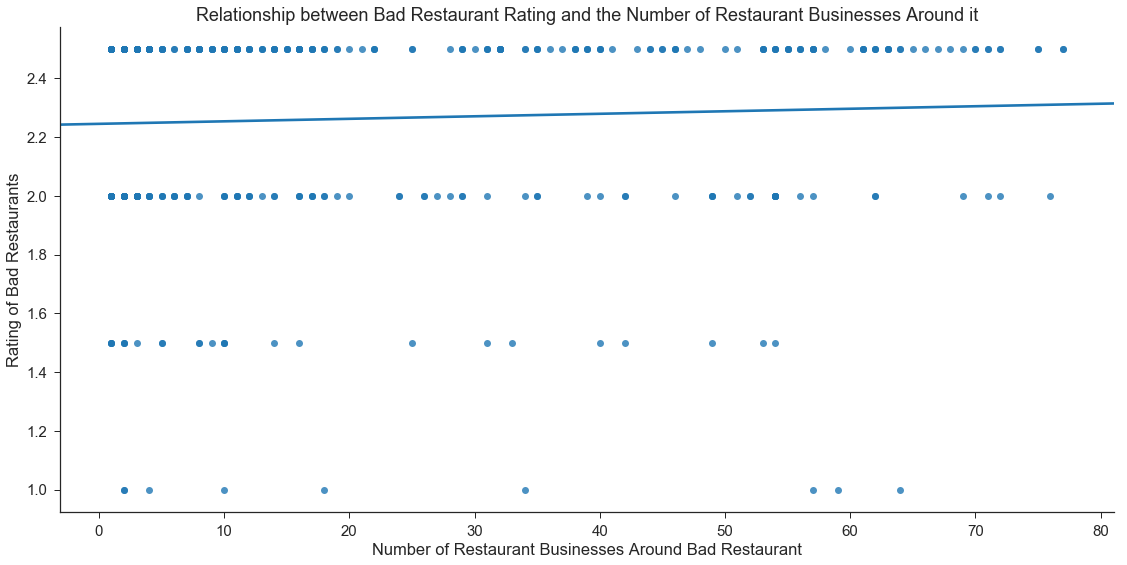

In [30]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="bad_restaurant_count", y="rating", size=8, ci=None, data=bad_restaurant_count_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Bad Restaurant Rating and the Number of Restaurant Businesses Around it")
plt.xlabel('Number of Restaurant Businesses Around Bad Restaurant')
plt.ylabel('Rating of Bad Restaurants')
plt.savefig("Relationship between Bad Restaurants and Number of Restaurants Around It.png")

In [31]:
fast_food = pd.DataFrame()
for lst in bad_restaurants_df['categories']:
    if "u'Fast Food'" not in lst:
        fast_food = fast_food.append(bad_restaurants_df[bad_restaurants_df['categories'] == lst])

In [121]:
jupyter nbconvert --to html mynotebook.ipynb


SyntaxError: invalid syntax (<ipython-input-121-542fb3cc3d83>, line 1)